---
### BottleNeck

---
#### BottleNeck이 Convolution 연산량에 어떠한 영향을 미치는가 확인

---

![vgg_architecture](/home/park/coding/study/DL/DeepLearning/VGG16/image/vgg16_architecture.png)

---

##### Import Lib

In [1]:
import torch
from torch.utils.data import DataLoader 
import torchvision
from torchvision import transforms as tf, datasets #torchvision모듈 내 transforms, datasets함수 임포트

import torch.nn as nn
import torch.nn.functional as f
from torchsummary import summary

from torch import optim
from torch.optim.lr_scheduler import StepLR


import matplotlib.pyplot as plt
import numpy as np

import json
import os
import time
import copy

/home/park/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

##### Dataset Path

In [2]:
# 데이터 셋 경로 지정
Path_MNIST = '../VGG16/data/MNIST/'
Path_STL10 = '../VGG16/data/STL10/'

##### Hyper Parameters

In [3]:
# 하이퍼 파라미터 지정
MNIST_BATCH_SIZE = 16
STL10_BATCH_SIZE = 4

CONV_KERNEL_SIZE = 3
c_stride = 1
c_padding = 1

MAXP_KERNEL_SIZE = 2
mp_stride = 2

lr = 0.01
step_size=30
gamma= 0.1


---

##### Define MNIST Data Transformation

In [4]:
# 데이터셋의 Transforms.Compose()를 통하여 가공한다. 
# rescale, randomCrop 등 다양하게 변경 가능하다. 

transform = tf.Compose([
    tf.Resize((224, 224)), # 이미지 사이즈 조정 
    tf.ToTensor(), # 텐서로 변환
    tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 데이터 정규화
])

---

##### MNIST Dataset Preparation

In [5]:
train_dataset = datasets.MNIST(root =Path_MNIST,
                               train = True,
                               download = True,
                               transform = tf.ToTensor( ))

In [6]:

test_dataset = datasets.MNIST(root =Path_MNIST,
                               train = False,
                               download = True,                            
                               transform = tf.ToTensor( ))


---

##### Define MNIST Data Loader

In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size =MNIST_BATCH_SIZE,
                                           shuffle = False)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = MNIST_BATCH_SIZE,
                                           shuffle = False)

---

##### Check MNIST Data

X_train: torch.Size([16, 1, 28, 28]) 
type: torch.FloatTensor
y_train: torch.Size([16]) 
type: torch.LongTensor
label: 1번
label: 2번
label: 6번
label: 0번
label: 7번
label: 8번
label: 9번
label: 2번
label: 9번
label: 5번


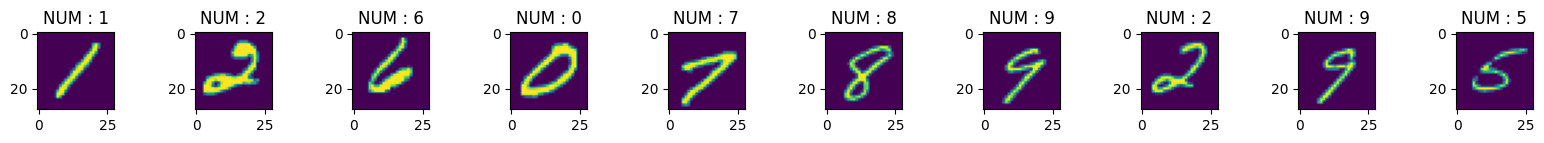

In [8]:
# 학습로더의 데이터를 xtrain 이미지, ytrain 라벨로 분리 
for (X_train, y_train) in train_loader: 
     X_train.size()
     X_train.type()
     y_train.size()
     y_train.type()
    
print('X_train:', X_train.size( ), '\ntype:', X_train.type( ))
print('y_train:', y_train.size( ), '\ntype:', y_train.type( ))
     
labels_map = {
    0: '0번',
    1: '1번',
    2: '2번',
    3: '3번',
    4: '4번',
    5: '5번',
    6: '6번',
    7: '7번',
    8: '8번',
    9: '9번',
}

pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.title("NUM : " + str(y_train[i].item()))
    label = labels_map[y_train[i].item()]
    print("label:", label)
    plt.imshow(X_train[i, :, :, :].numpy( ).reshape(28,28))
     

---

##### STL10 Dataset Preparation

In [9]:
STL_train_dataset = datasets.STL10(root =Path_STL10,
                               split='train',
                               download = True,
                               transform = tf.ToTensor())

Files already downloaded and verified


In [10]:

STL_test_dataset = datasets.STL10(root =Path_STL10,
                               split='test',
                               download = True,                            
                               transform = tf.ToTensor())

Files already downloaded and verified


---

##### Check STL10 Data

In [11]:
img, _ = STL_train_dataset[1]
print("stl img shape: ", img.shape) # size = [3, 96, 96]
print("len stl_train", len(STL_train_dataset)) # 학습용 데이터 5000개
print("len stl_test", len(STL_test_dataset))   # 테스트 데이터 8000개

stl img shape:  torch.Size([3, 96, 96])
len stl_train 5000
len stl_test 8000


---

##### Calculate STL10 Data Normalization

##### 1. Get STL Train Normalization  
###### 1-1. STL Train Mean and STD

In [12]:
STL_train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in STL_train_dataset]
STL_train_stdRGB  = [np.std(x.numpy(), axis=(1,2))  for x, _ in STL_train_dataset]

STL_train_meanR = np.mean([m[0] for m in STL_train_meanRGB])
STL_train_meanG = np.mean([m[1] for m in STL_train_meanRGB])
STL_train_meanB = np.mean([m[2] for m in STL_train_meanRGB])
STL_train_stdR  = np.std([s[0] for s in STL_train_stdRGB])
STL_train_stdG  = np.std([s[1] for s in STL_train_stdRGB])
STL_train_stdB  = np.std([s[2] for s in STL_train_stdRGB])

print("STL_train_meanR: ",STL_train_meanR) #STL_train_meanR:  0.4467106
print("STL_train_meanG: ",STL_train_meanG) #STL_train_meanG:  0.43980986
print("STL_train_meanB: ",STL_train_meanB) #STL_train_meanB:  0.40664646
print("STL_train_stdR: ", STL_train_stdR)  #STL_train_stdR:   0.061958
print("STL_train_stdG: ", STL_train_stdG)  #STL_train_stdG:   0.06189533
print("STL_train_stdB: ", STL_train_stdB)  #STL_train_stdB:   0.068922155

STL_train_meanR:  0.4467106
STL_train_meanG:  0.43980986
STL_train_meanB:  0.40664646
STL_train_stdR:  0.061958
STL_train_stdG:  0.06189533
STL_train_stdB:  0.068922155


###### 1-2. STL test Mean and STD

In [13]:
STL_test_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in STL_test_dataset]
STL_test_stdRGB  = [np.std(x.numpy(), axis=(1,2))  for x, _ in STL_test_dataset]

STL_test_meanR = np.mean([m[0] for m in STL_test_meanRGB])
STL_test_meanG = np.mean([m[1] for m in STL_test_meanRGB])
STL_test_meanB = np.mean([m[2] for m in STL_test_meanRGB])
STL_test_stdR  = np.std( [s[0] for s in STL_test_stdRGB])
STL_test_stdG  = np.std( [s[1] for s in STL_test_stdRGB])
STL_test_stdB  = np.std( [s[2] for s in STL_test_stdRGB])

print("STL_test_meanR: ",STL_test_meanR) #STL_test_meanR:  0.44723064
print("STL_test_meanG: ",STL_test_meanG) #STL_test_meanG:  0.4396425
print("STL_test_meanB: ",STL_test_meanB) #STL_test_meanB:  0.40495726
print("STL_test_stdR: ", STL_test_stdR)  #STL_test_stdR:   0.0617221
print("STL_test_stdG: ", STL_test_stdG)  #STL_test_stdG:   0.06181906
print("STL_test_stdB: ", STL_test_stdB)  #STL_test_stdB:   0.06902452

STL_test_meanR:  0.44723064
STL_test_meanG:  0.4396425
STL_test_meanB:  0.40495726
STL_test_stdR:  0.0617221
STL_test_stdG:  0.06181906
STL_test_stdB:  0.06902452


---

##### Define STL10 Data Transformation

In [14]:
STL_train_transformer = tf.Compose([
    tf.Resize(224),
    tf.ToTensor(),
    tf.Normalize([STL_train_meanR, STL_train_meanG, STL_train_meanB], [STL_train_stdR, STL_train_stdG, STL_train_stdB]),
])
STL_train_dataset.transform = STL_train_transformer
STL_test_dataset.transform = STL_train_transformer


---

##### Load Transform STL10 Image

image index:  2732
image shape:  torch.Size([3, 224, 224])
np_img shape:  (224, 224)
np_img shape:  (224, 224)
np_img shape:  (224, 224)


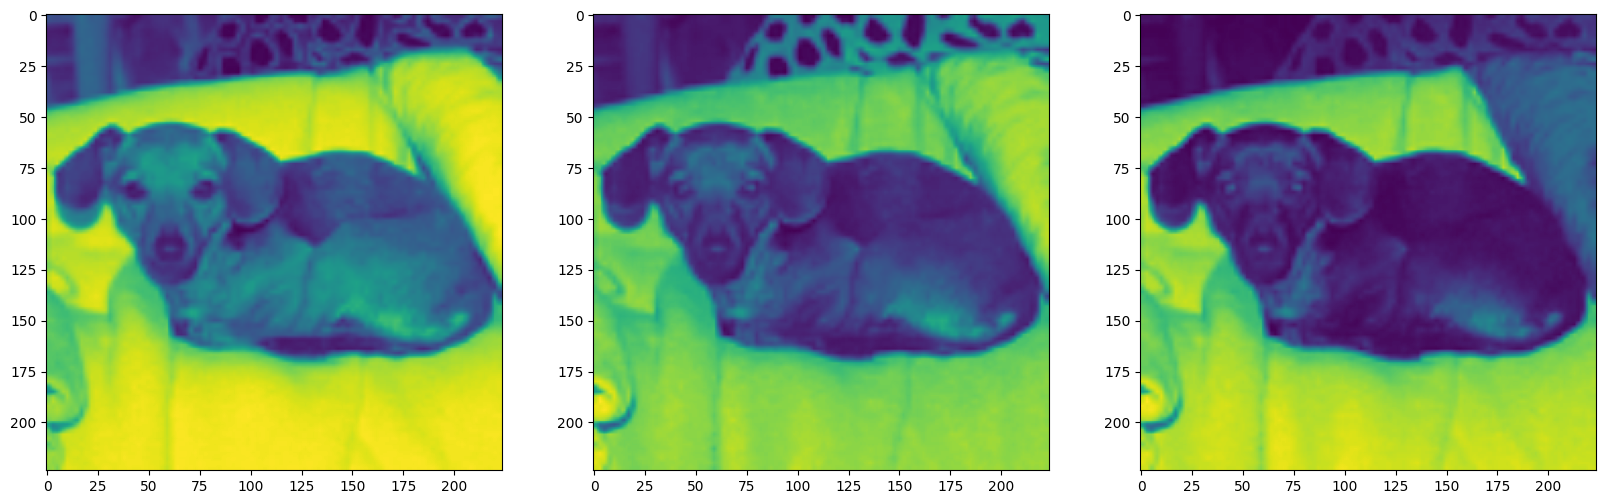

In [15]:
def show_img(imgs, y=None, color=True):
    for i, img in enumerate(imgs):
        np_img = img.numpy()
        print("np_img shape: ", np_img.shape)
        #np_img_tr = np.transpose(np_img, (0, 1, 2))
        plt.subplot(1, imgs.shape[0], i+1)
        plt.imshow(np_img)
        
    if y is not None:
        plt.title('labels: ' + str(y))

np.random.seed(0)
torch.manual_seed(0)

rnd_idx = int(np.random.randint(0, len(STL_train_dataset) ,1))
img, label = STL_train_dataset[rnd_idx]
print("image index: ", rnd_idx)
print("image shape: ", img.shape)

plt.figure(figsize=(20,20))
show_img(img)
        

---

##### STL10 DataLoader

In [16]:
STL_train_dl = DataLoader(STL_train_dataset, batch_size=STL10_BATCH_SIZE, shuffle=True)
STL_test_dl = DataLoader(STL_test_dataset, batch_size=STL10_BATCH_SIZE, shuffle=True)

print("size: ",len(STL_train_dl))

size:  1250


---

##### VGG Models
###### 4가지 종류의 VGG 모델을 딕셔너리로 정의

In [17]:
VGG_Type = {
    'VGG11': [64, 'MP', 128, 'MP', 256, 256, 'MP', 512, 512, 'MP', 512, 512, 'MP'],
    'VGG13': [64, 64, 'MP', 128, 128, 'MP', 256, 256, 'MP', 512, 512, 'MP', 512, 512, 'MP'],
    'VGG16': [64, 64, 'MP', 128, 128, 'MP', 256, 256, 256, 'MP', 512, 512, 512, 'MP', 512, 512, 512, 'MP'],
    'VGG19': [64, 64, 'MP', 128, 128, 'MP', 256, 256, 256, 256, 'MP', 512, 512, 512, 512,  'MP', 512, 512, 512, 512, 'MP']
}

###### VGGnet 생성

In [32]:
class VGGnet(nn.Module):
    def __init__(self, model, in_ch=3, cls = 10, init_w=True):
        super(VGGnet, self).__init__()
        self.in_ch = in_ch
        self.conv_layers = self.create_conv_layers(VGG_Type[model])
        self.fc = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, cls),
        )
        if init_w: 
            self.init_weight()
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 512*7*7)
        x = self.fc(x)
        return x
    
    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode ='fan_out', nonlinearity='relu')
                if m.bias is not None: 
                    nn.init.constant_(m.bias, 0)
            
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def create_conv_layers(self, architecture):
        layers = []
        in_chs = self.in_ch
        
        for x in architecture:
            if type(x) == int:
                out_ch = x
                layers += [nn.Conv2d(in_channels=in_chs, out_channels=out_ch, kernel_size=(CONV_KERNEL_SIZE,CONV_KERNEL_SIZE), stride=(c_stride,c_stride), padding=(c_padding,c_padding)),
                                     nn.BatchNorm2d(x), nn.ReLU()]
                in_chs = x 
        
            elif x == 'MP':
                layers += [nn.MaxPool2d(kernel_size=(MAXP_KERNEL_SIZE,MAXP_KERNEL_SIZE), stride=(mp_stride,mp_stride))]
            
        return nn.Sequential(*layers)
        

---

##### Define Device

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

model = VGGnet('VGG16', in_ch=3, cls=10, init_w=True).to(device)

In [20]:
summary(model, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

---

##### VGG16 모델 학습

In [21]:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr = lr)

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
    
current_lr = get_lr(opt)
print('current lr : ', current_lr)

lr_scheduler = StepLR(opt, step_size=step_size, gamma=gamma)

current lr :  0.01


In [22]:
def metrics_batch(output, target):
    pred = output.argmax(dim =1, keepdim = True)
    corrects =pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [23]:
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metrics_b = metrics_batch(output, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metrics_b

In [24]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check = False, opt = None):
    running_loss = 0.0
    running_metric = 0.0
    
    len_data = len(dataset_dl.dataset)
    
    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        
        #bs, ncrops, c, h, w = xb.size()
        bs, c, h, w = xb.size()
        
        output = model(xb.view(-1, c, h, w))
        #output = output_.view(bs, ncrops, -1).mean(1)
        
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        
        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break
        
    loss = running_loss/float(len_data)
    metric = running_metric/float(len_data)
    
    return loss, metric
        

In [25]:
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    STL_train_dl=params["STL_train_dl"]
    STL_test_dl=params["STL_test_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # 가중치를 저장할 때, 코랩 GPU 오류나서 생략했습니다.
    # a deep copy of weights for the best performing model
    # best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        # check 1 epoch start time
        start_time = time.time()

        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,STL_train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,STL_test_dl,sanity_check)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # # store weights into a local file
            # torch.save(model.state_dict(), path2weights)
            # print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step()

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f, time: %.4f s" %(train_loss,val_loss,100*val_metric, time.time()-start_time))
        print("-"*10) 

    ## load best model weights
    # model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [26]:
# definc the training parameters
params_train = {
    'num_epochs':10,
    'optimizer':opt,
    'loss_func':loss_func,
    'STL_train_dl':STL_train_dl,
    'STL_test_dl':STL_test_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except :
        return 'error'
createFolder('./models')

In [27]:
model, loss_hist, metric_hist = train_val(model, params_train)


'''
Epoch 0/9, current lr=0.01
train loss: 37.785340, dev loss: 2.312025, accuracy: 10.00, time: 69.1135 s
----------
Epoch 1/9, current lr=0.01
train loss: 2.368147, dev loss: 2.353051, accuracy: 9.96, time: 69.1780 s
----------
Epoch 2/9, current lr=0.01
train loss: 2.308697, dev loss: 2.338136, accuracy: 10.03, time: 69.5452 s
----------
Epoch 3/9, current lr=0.01
train loss: 2.307257, dev loss: 2.323257, accuracy: 10.00, time: 69.4685 s
----------
Epoch 4/9, current lr=0.01
train loss: 2.307029, dev loss: 2.406964, accuracy: 10.00, time: 69.2392 s
----------
Epoch 5/9, current lr=0.01
train loss: 2.307344, dev loss: 2.363191, accuracy: 10.01, time: 69.2876 s
----------
Epoch 6/9, current lr=0.01
train loss: 2.306746, dev loss: 2.306207, accuracy: 10.00, time: 68.9240 s
----------
Epoch 7/9, current lr=0.01
train loss: 2.307348, dev loss: 2.320690, accuracy: 10.04, time: 72.0590 s
----------
Epoch 8/9, current lr=0.01
train loss: 2.306728, dev loss: 2.313578, accuracy: 10.01, time: 68.7770 s
----------
Epoch 9/9, current lr=0.01
train loss: 2.307426, dev loss: 2.389519, accuracy: 10.00, time: 71.4827 s
----------

'''

Epoch 0/9, current lr=0.01
train loss: 41.229711, dev loss: 2.388299, accuracy: 10.01, time: 69.0169 s
----------
Epoch 1/9, current lr=0.01
train loss: 2.352614, dev loss: 2.460063, accuracy: 9.99, time: 68.7628 s
----------
Epoch 2/9, current lr=0.01
train loss: 2.435222, dev loss: 2.305655, accuracy: 10.00, time: 69.2694 s
----------
Epoch 3/9, current lr=0.01
train loss: 2.307837, dev loss: 2.307050, accuracy: 10.00, time: 68.9443 s
----------
Epoch 4/9, current lr=0.01
train loss: 2.307089, dev loss: 2.305843, accuracy: 10.00, time: 68.6233 s
----------
Epoch 5/9, current lr=0.01
train loss: 2.307396, dev loss: 2.305641, accuracy: 10.00, time: 68.3279 s
----------
Epoch 6/9, current lr=0.01
train loss: 2.306746, dev loss: 2.306466, accuracy: 10.00, time: 68.4135 s
----------
Epoch 7/9, current lr=0.01
train loss: 2.307348, dev loss: 2.303916, accuracy: 10.00, time: 68.4071 s
----------
Epoch 8/9, current lr=0.01
train loss: 2.306728, dev loss: 2.305621, accuracy: 10.00, time: 68.4

'\nEpoch 0/9, current lr=0.01\ntrain loss: 37.785340, dev loss: 2.312025, accuracy: 10.00, time: 69.1135 s\n----------\nEpoch 1/9, current lr=0.01\ntrain loss: 2.368147, dev loss: 2.353051, accuracy: 9.96, time: 69.1780 s\n----------\nEpoch 2/9, current lr=0.01\ntrain loss: 2.308697, dev loss: 2.338136, accuracy: 10.03, time: 69.5452 s\n----------\nEpoch 3/9, current lr=0.01\ntrain loss: 2.307257, dev loss: 2.323257, accuracy: 10.00, time: 69.4685 s\n----------\nEpoch 4/9, current lr=0.01\ntrain loss: 2.307029, dev loss: 2.406964, accuracy: 10.00, time: 69.2392 s\n----------\nEpoch 5/9, current lr=0.01\ntrain loss: 2.307344, dev loss: 2.363191, accuracy: 10.01, time: 69.2876 s\n----------\nEpoch 6/9, current lr=0.01\ntrain loss: 2.306746, dev loss: 2.306207, accuracy: 10.00, time: 68.9240 s\n----------\nEpoch 7/9, current lr=0.01\ntrain loss: 2.307348, dev loss: 2.320690, accuracy: 10.04, time: 72.0590 s\n----------\nEpoch 8/9, current lr=0.01\ntrain loss: 2.306728, dev loss: 2.313578,

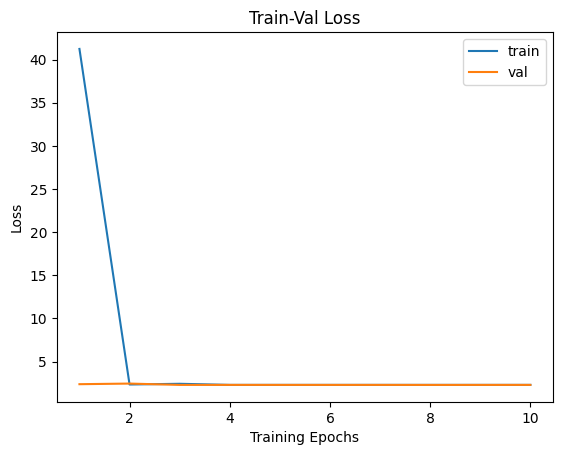

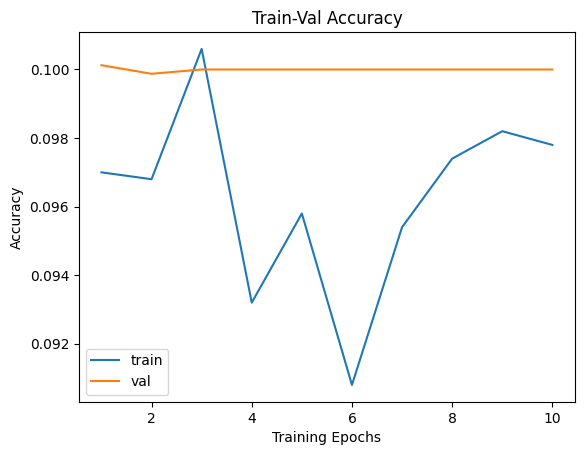

In [28]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()